# Redes Neuronales.

In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

notebookstart= time.time()

Tensorflow Version: 2.9.2
Pandas Version: 1.3.5
Numpy Version: 1.21.6
System Version: 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]


In [2]:
import IPython
import IPython.display

## Datos

In [3]:
df = pd.read_csv("bitcoin.csv")
df['Fecha']=pd.to_datetime(df['Fecha'])
print("DataFrame Shape: {} rows, {} columns".format(*df.shape))
display(df.head())

DataFrame Shape: 1410 rows, 8 columns


,Unnamed: 0,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
0,1,2022-11-10,17589.1,15887.0,18138.2,15799.3,"720,74K","10,71%"
1,2,2022-11-09,15886.9,18538.9,18583.8,15603.3,"869,57K","-14,25%"
2,3,2022-11-08,18527.4,20589.0,20667.5,17260.0,"865,10K","-10,01%"
3,4,2022-11-07,20589.0,20916.3,21055.4,20410.5,"414,24K","-1,56%"
4,5,2022-11-06,20916.3,21298.7,21360.4,20901.0,"242,26K","-1,81%"


## Predicción Univariada

In [34]:
features_considered = ['Apertura']

In [35]:
features = df[features_considered]
features.index = df['Fecha']
features.head()

,Apertura
Fecha,
2022-11-10,15887.0
2022-11-09,18538.9
2022-11-08,20589.0
2022-11-07,20916.3
2022-11-06,21298.7


array([<AxesSubplot:xlabel='Fecha'>], dtype=object)

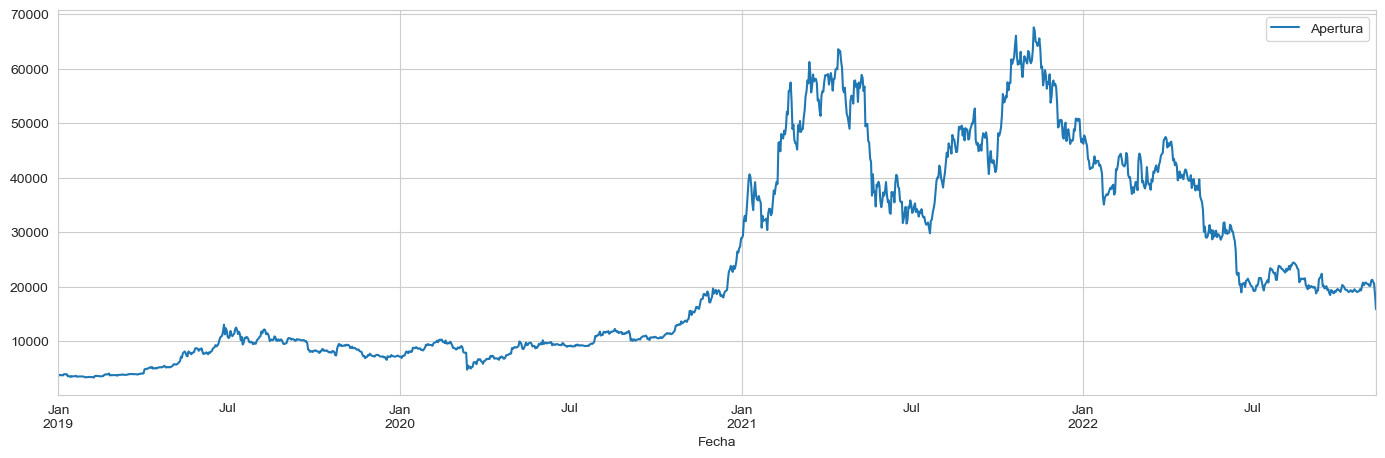

In [36]:
features.plot(subplots=True)

## Separacion(Entrenamiento-Validación-Prueba) y Normalización.

In [37]:
column_indices = {name: i for i, name in enumerate(features.columns)}

n = len(features)
train_df = features[0:int(n*0.7)]
val_df = features[int(n*0.7):int(n*0.9)]
test_df = features[int(n*0.9):]

num_features = features.shape[1]
train_mean = train_df.mean()

In [38]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [39]:
train_df

,Apertura
Fecha,
2022-11-10,-0.867991
2022-11-09,-0.712535
2022-11-08,-0.592358
2022-11-07,-0.573171
2022-11-06,-0.550755
...,...
2020-03-04,-1.285703
2020-03-03,-1.277214
2020-03-02,-1.298822


In [40]:
print("longitud dataframe entrenamiento:",train_df.shape)
print("longitud dataframe validación:",val_df.shape)
print("longitud dataframe prueba:",test_df.shape)

longitud dataframe entrenamiento: (986, 1)
longitud dataframe validación: (283, 1)
longitud dataframe prueba: (141, 1)


In [41]:
df_std = (features - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
df_std

,Column,Normalized
0,Apertura,-0.867991
1,Apertura,-0.712535
2,Apertura,-0.592358
3,Apertura,-0.573171
4,Apertura,-0.550755
...,...,...
1405,Apertura,-1.576372
1406,Apertura,-1.577679
1407,Apertura,-1.572192
1408,Apertura,-1.575967


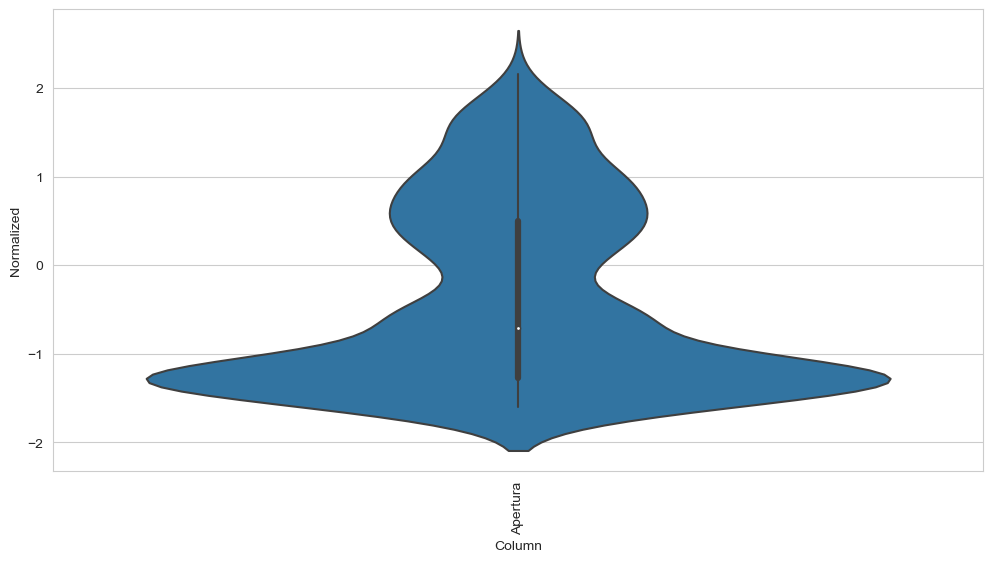

In [42]:
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(features.keys(), rotation=90)

## Clase WindowGenerator

In [43]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

## Split
Dada una lista de entradas consecutivas, el método split_window las convertirá en una ventana de entradas y una ventana de etiquetas.

In [44]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

## Transforma nuestros objetos a tipo tensorflow
Acá debe especificarse el tamaño del lote en batch_size=128 por defecto en la función make_dataset. Debe tener shuffle=False en el argumento de la función.

In [45]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=128,)## cambiar 128

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [46]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [47]:
def plot(self, model=None, plot_col='Apertura', max_subplots=2):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

## Definir las gráficas para visulaizar lo que se desea predecir en términos de las entradas
Note que puede cambiar el nombre de la variable que va a visualiza usando el argumento plot_col

In [48]:
def plot(self, model=None, plot_col='Apertura', max_subplots=2):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

## Configuración para el ajuste de los modelos

In [49]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=0):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# Modelamiento para la predicción de un solo paso

## Denso(MLP)

Ajustaremos una red perceptrón multicapa con dos capas ocultas y usando función de activación RELU.

In [50]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Apertura'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Apertura']

In [51]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Forma(dimensión) de la entrada Apertura: {example_inputs.shape}')
  print(f'Forma(dimensión) de la etiqueta, salida o respuesta Apertura: {example_labels.shape}')

Forma(dimensión) de la entrada Apertura: (128, 1, 1)
Forma(dimensión) de la etiqueta, salida o respuesta Apertura: (128, 1, 1)


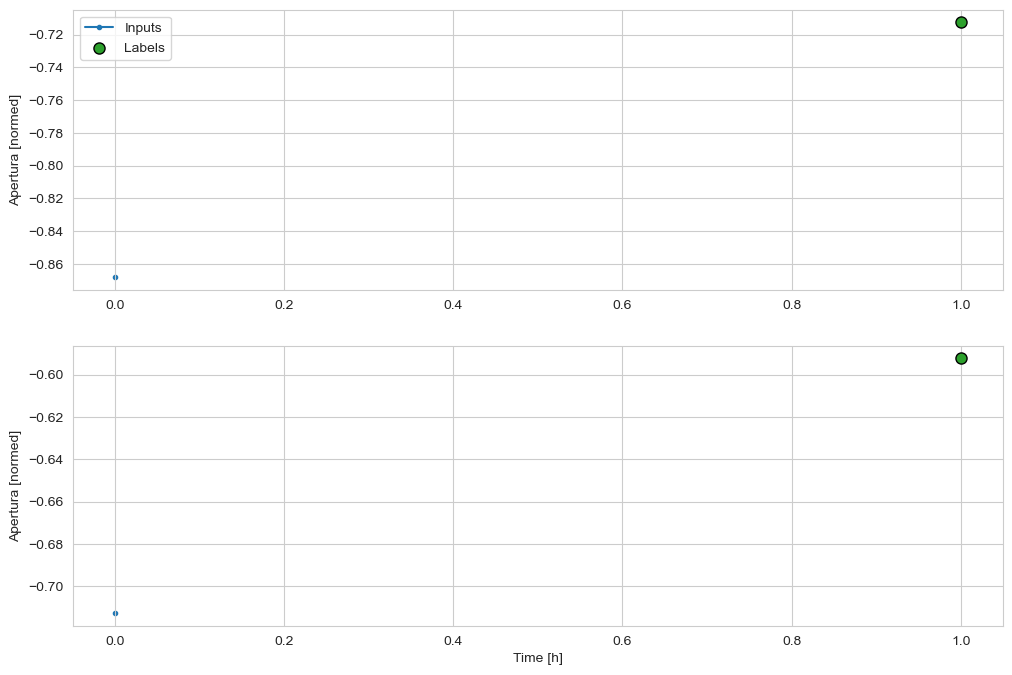

In [52]:
single_step_window.plot()

In [53]:
i=1
for batch in single_step_window.train.take(2):
    inputs, targets = batch
    print("Covariable o input del lote",i,inputs)
    print("Respuesta o etiqueta del lote ",i,targets)
    print("tipo de objeto inputs del lote",i,type(inputs))
    i=i+1

Covariable o input del lote 1 tf.Tensor(
[[[-0.867991  ]]

 [[-0.7125355 ]]

 [[-0.59235775]]

 [[-0.57317126]]

 [[-0.55075485]]

 [[-0.55972373]]

 [[-0.6147859 ]]

 [[-0.61785764]]

 [[-0.5985774 ]]

 [[-0.5978036 ]]

 [[-0.5901888 ]]

 [[-0.5794378 ]]

 [[-0.59205294]]

 [[-0.6097094 ]]

 [[-0.58177674]]

 [[-0.6217969 ]]

 [[-0.6660553 ]]

 [[-0.6520216 ]]

 [[-0.6735001 ]]

 [[-0.6759739 ]]

 [[-0.6829908 ]]

 [[-0.6781722 ]]

 [[-0.6662664 ]]

 [[-0.65335816]]

 [[-0.6701353 ]]

 [[-0.6814725 ]]

 [[-0.6748543 ]]

 [[-0.66324157]]

 [[-0.67644286]]

 [[-0.6820763 ]]

 [[-0.67763287]]

 [[-0.65961295]]

 [[-0.66110194]]

 [[-0.654425  ]]

 [[-0.6290893 ]]

 [[-0.6176525 ]]

 [[-0.6069249 ]]

 [[-0.6485923 ]]

 [[-0.6821291 ]]

 [[-0.6672219 ]]

 [[-0.66071504]]

 [[-0.65072024]]

 [[-0.6608733 ]]

 [[-0.6806167 ]]

 [[-0.6720932 ]]

 [[-0.69704795]]

 [[-0.6898963 ]]

 [[-0.6685995 ]]

 [[-0.6618171 ]]

 [[-0.7155134 ]]

 [[-0.6928273 ]]

 [[-0.65391505]]

 [[-0.66103745]]

 [[-0

## Tamaño del conjunto de datos de entrenamiento, validación y prueba

In [54]:
dataset_train_len = len(list(single_step_window.train.unbatch().map(lambda x, y: (x, y))))
dataset_val_len = len(list(single_step_window.val.unbatch().map(lambda x, y: (x, y))))
dataset_test_len = len(list(single_step_window.test.unbatch().map(lambda x, y: (x, y))))

In [55]:
print("longitud datos de entrenamiento:",dataset_train_len)
print("longitud datos de validación:",dataset_val_len)
print("longitud datos de prueba:",dataset_test_len)

longitud datos de entrenamiento: 985
longitud datos de validación: 282
longitud datos de prueba: 140


## Denso(MLP)
Ajustaremos una red perceptrón multicapa con dos capas ocultas y usando función de activación RELU.

In [56]:
single_step_window
val_performance = {}
performance = {}

In [57]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),# cambiar 64
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
8/8 [==============================] - 0s 15ms/step - loss: 0.8674 - mean_absolute_error: 0.7791 - val_loss: 0.4730 - val_mean_absolute_error: 0.6861
Epoch 2/20
3/3 [==============================] - 0s 1ms/step - loss: 0.2268 - mean_absolute_error: 0.4748


In [58]:
dense.evaluate(single_step_window.test,verbose=1)

2/2 [==============================] - 0s 1ms/step - loss: 0.3487 - mean_absolute_error: 0.5899


[0.3487303555011749, 0.5899044275283813]

<AxesSubplot:>

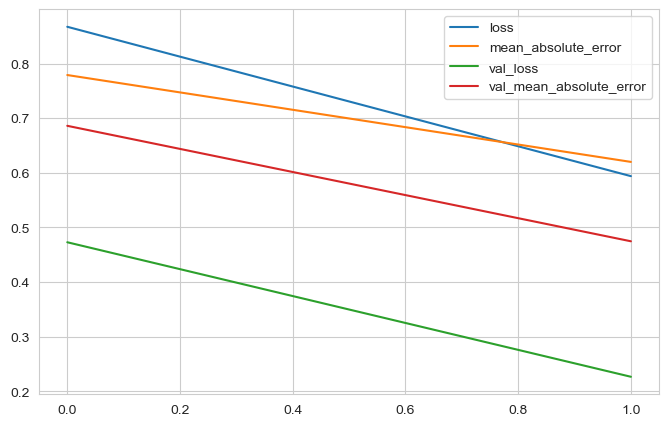

In [59]:
pd.DataFrame(history.history).plot(figsize=(8,5))

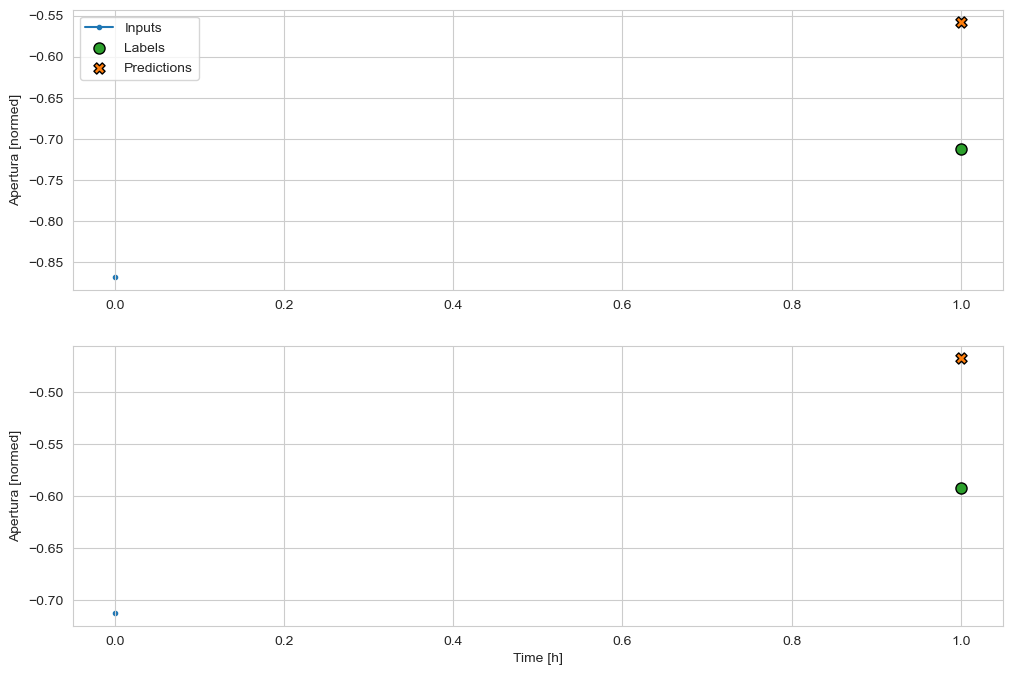

In [60]:
single_step_window.plot(dense)

## Prediccion 

In [61]:
test_df.shape

(141, 1)

In [62]:
print(test_df.tail(10))

input_predict=tf.constant(np.array(test_df.iloc[140]),dtype=tf.float32, shape=(1,1,1))
print(input_predict)
input_predict_mlp=input_predict
# toma el ultimo registro del conjunto de prueba y hace la prediccion conviertiendolo en un tensor

            Apertura
Fecha               
2019-01-10 -1.566049
2019-01-09 -1.566512
2019-01-08 -1.565644
2019-01-07 -1.564560
2019-01-06 -1.577374
2019-01-05 -1.576372
2019-01-04 -1.577679
2019-01-03 -1.572192
2019-01-02 -1.575967
2019-01-01 -1.581841
tf.Tensor([[[-1.5818412]]], shape=(1, 1, 1), dtype=float32)


In [63]:
dense.predict(input_predict)# prediccion, respuesta normalizada

1/1 [==============================] - 0s 75ms/step


array([[[-0.9746787]]], dtype=float32)

# Errores de Predicción del Modelo

## Sobre el conjunto de entrenamiento

In [64]:
labels_train = np.concatenate([y for x, y in single_step_window.train], axis=0)

In [65]:
labels_train # respuestas sobre el conjunto de entrenamiento 

array([[[-0.7125355 ]],

       [[-0.59235775]],

       [[-0.57317126]],

       [[-0.55075485]],

       [[-0.55972373]],

       [[-0.6147859 ]],

       [[-0.61785764]],

       [[-0.5985774 ]],

       [[-0.5978036 ]],

       [[-0.5901888 ]],

       [[-0.5794378 ]],

       [[-0.59205294]],

       [[-0.6097094 ]],

       [[-0.58177674]],

       [[-0.6217969 ]],

       [[-0.6660553 ]],

       [[-0.6520216 ]],

       [[-0.6735001 ]],

       [[-0.6759739 ]],

       [[-0.6829908 ]],

       [[-0.6781722 ]],

       [[-0.6662664 ]],

       [[-0.65335816]],

       [[-0.6701353 ]],

       [[-0.6814725 ]],

       [[-0.6748543 ]],

       [[-0.66324157]],

       [[-0.67644286]],

       [[-0.6820763 ]],

       [[-0.67763287]],

       [[-0.65961295]],

       [[-0.66110194]],

       [[-0.654425  ]],

       [[-0.6290893 ]],

       [[-0.6176525 ]],

       [[-0.6069249 ]],

       [[-0.6485923 ]],

       [[-0.6821291 ]],

       [[-0.6672219 ]],

       [[-0.66071504]],



In [66]:
labels_train.shape

(985, 1, 1)

In [67]:
lista=list(single_step_window.train.unbatch().map(lambda x, y: (x, y)))

In [68]:
prediccion_intra_muestra=dense.predict(single_step_window.train, verbose=1) # computa la prediccion sobre el conjunto de entrenamiento 

8/8 [==============================] - 0s 1ms/step


In [69]:
prediccion_intra_muestra

array([[[-0.55837893]],

       [[-0.4677212 ]],

       [[-0.3976283 ]],

       [[-0.38642818]],

       [[-0.3733427 ]],

       [[-0.37857828]],

       [[-0.41071606]],

       [[-0.41250736]],

       [[-0.40125895]],

       [[-0.40080726]],

       [[-0.39636216]],

       [[-0.3900863 ]],

       [[-0.39745036]],

       [[-0.40775552]],

       [[-0.39145163]],

       [[-0.4148047 ]],

       [[-0.44061512]],

       [[-0.43243098]],

       [[-0.44495672]],

       [[-0.4463994 ]],

       [[-0.4504915 ]],

       [[-0.44768137]],

       [[-0.44073814]],

       [[-0.43321043]],

       [[-0.44299448]],

       [[-0.449606  ]],

       [[-0.44574642]],

       [[-0.4389742 ]],

       [[-0.44667286]],

       [[-0.44995815]],

       [[-0.44736683]],

       [[-0.43685806]],

       [[-0.4377264 ]],

       [[-0.43383256]],

       [[-0.41905746]],

       [[-0.41238776]],

       [[-0.40613168]],

       [[-0.4304311 ]],

       [[-0.4499889 ]],

       [[-0.4412954 ]],



In [70]:
prediccion_intra_muestra.shape

(985, 1, 1)

In [71]:
eror_prediction_train=labels_train-prediccion_intra_muestra

In [72]:

eror_prediction_train

array([[[-1.54156566e-01]],

       [[-1.24636561e-01]],

       [[-1.75542951e-01]],

       [[-1.64326668e-01]],

       [[-1.86381042e-01]],

       [[-2.36207634e-01]],

       [[-2.07141578e-01]],

       [[-1.86070025e-01]],

       [[-1.96544647e-01]],

       [[-1.89381540e-01]],

       [[-1.83075637e-01]],

       [[-2.01966643e-01]],

       [[-2.12259024e-01]],

       [[-1.74021214e-01]],

       [[-2.30345279e-01]],

       [[-2.51250625e-01]],

       [[-2.11406469e-01]],

       [[-2.41069138e-01]],

       [[-2.31017172e-01]],

       [[-2.36591399e-01]],

       [[-2.27680683e-01]],

       [[-2.18585014e-01]],

       [[-2.12620020e-01]],

       [[-2.36924887e-01]],

       [[-2.38478005e-01]],

       [[-2.25248277e-01]],

       [[-2.17495143e-01]],

       [[-2.37468660e-01]],

       [[-2.35403419e-01]],

       [[-2.27674723e-01]],

       [[-2.12246120e-01]],

       [[-2.24243879e-01]],

       [[-2.16698617e-01]],

       [[-1.95256740e-01]],

       [[-1.98

In [73]:
x_vals = train_df.index[1:]

In [74]:
print(eror_prediction_train.shape)# dimensiones 
print(x_vals.shape)

(985, 1, 1)
(985,)


In [75]:
eror_prediction_train=eror_prediction_train.reshape(eror_prediction_train.shape[0])# se devuelve los lotes

In [76]:
eror_prediction_train# valores errores de prediccion

array([-1.54156566e-01, -1.24636561e-01, -1.75542951e-01, -1.64326668e-01,
       -1.86381042e-01, -2.36207634e-01, -2.07141578e-01, -1.86070025e-01,
       -1.96544647e-01, -1.89381540e-01, -1.83075637e-01, -2.01966643e-01,
       -2.12259024e-01, -1.74021214e-01, -2.30345279e-01, -2.51250625e-01,
       -2.11406469e-01, -2.41069138e-01, -2.31017172e-01, -2.36591399e-01,
       -2.27680683e-01, -2.18585014e-01, -2.12620020e-01, -2.36924887e-01,
       -2.38478005e-01, -2.25248277e-01, -2.17495143e-01, -2.37468660e-01,
       -2.35403419e-01, -2.27674723e-01, -2.12246120e-01, -2.24243879e-01,
       -2.16698617e-01, -1.95256740e-01, -1.98595017e-01, -1.94537133e-01,
       -2.42460608e-01, -2.51697987e-01, -2.17233002e-01, -2.19419658e-01,
       -2.13219434e-01, -2.29201257e-01, -2.43023634e-01, -2.22986281e-01,
       -2.52911687e-01, -2.31207013e-01, -2.14080930e-01, -2.19718277e-01,
       -2.77369946e-01, -2.23369479e-01, -1.97687179e-01, -2.27502286e-01,
       -1.82519525e-01, -

In [77]:
eror_prediction_train.shape# misma dimension de la diferencia

(985,)

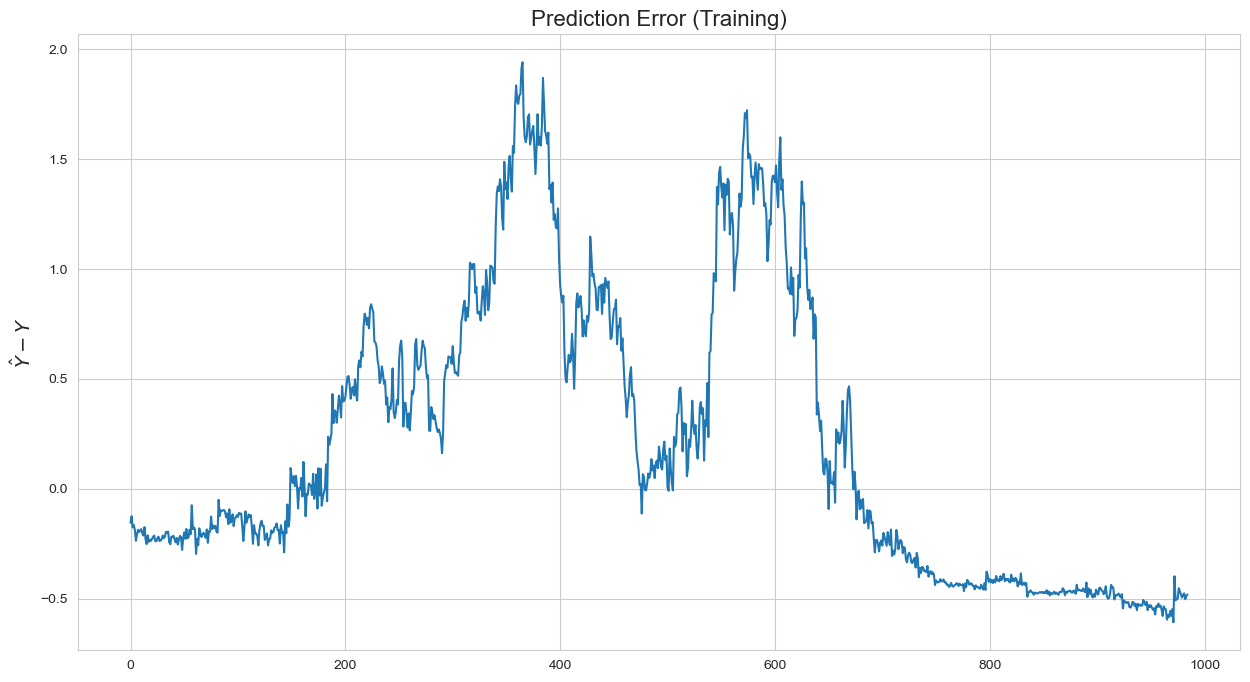

In [78]:
fig = plt.figure(figsize=(15,8))
plt.plot(eror_prediction_train)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)# idealmente debe ser iid, o estacionario para poder estimar de manera correcta el riesgo, lo mas importatnte es que el modelo no tenga con tendencia
plt.title('Prediction Error (Training)', fontsize=16);# y se esta minimizando el riesgo de forma correcta
#iid el mejor de los casos para calcular un valor esperado

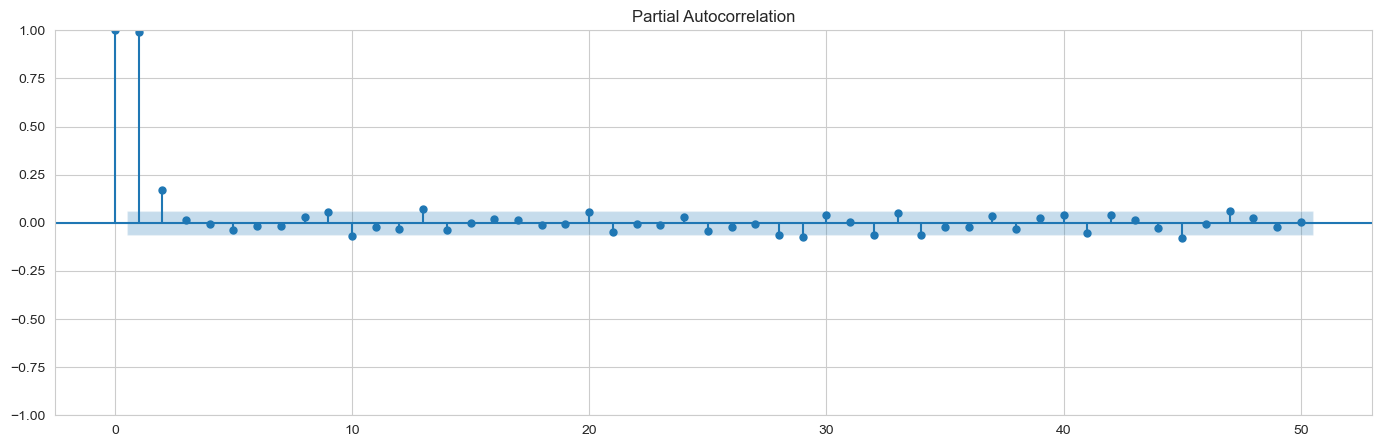

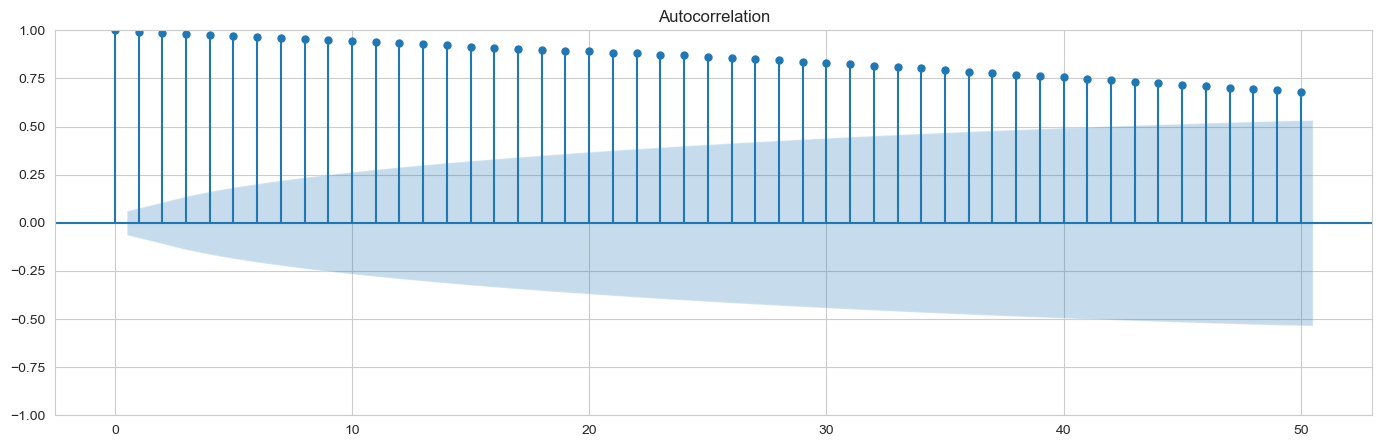

In [79]:
graficapacf=plot_pacf(eror_prediction_train,lags=50,method='ldbiased') ###Se puede usar también em method='ywmle'
graficaacf=plot_acf(eror_prediction_train,lags=50,adjusted='ldbiased')


## Sobre el conjunto de Prueba

In [80]:
labels_test = np.concatenate([y for x, y in single_step_window.test], axis=0)# lo mismo para el conjunto de prueba

In [81]:
prediccion_conjunto_test=dense.predict(single_step_window.test, verbose=1)# abajo aparece 2 porque es el numero de lotes

2/2 [==============================] - 0s 2ms/step


In [82]:
eror_prediction_test=labels_test-prediccion_conjunto_test

In [83]:
eror_prediction_test.shape

(140, 1, 1)

In [84]:
eror_prediction_test=eror_prediction_test.reshape(eror_prediction_test.shape[0])

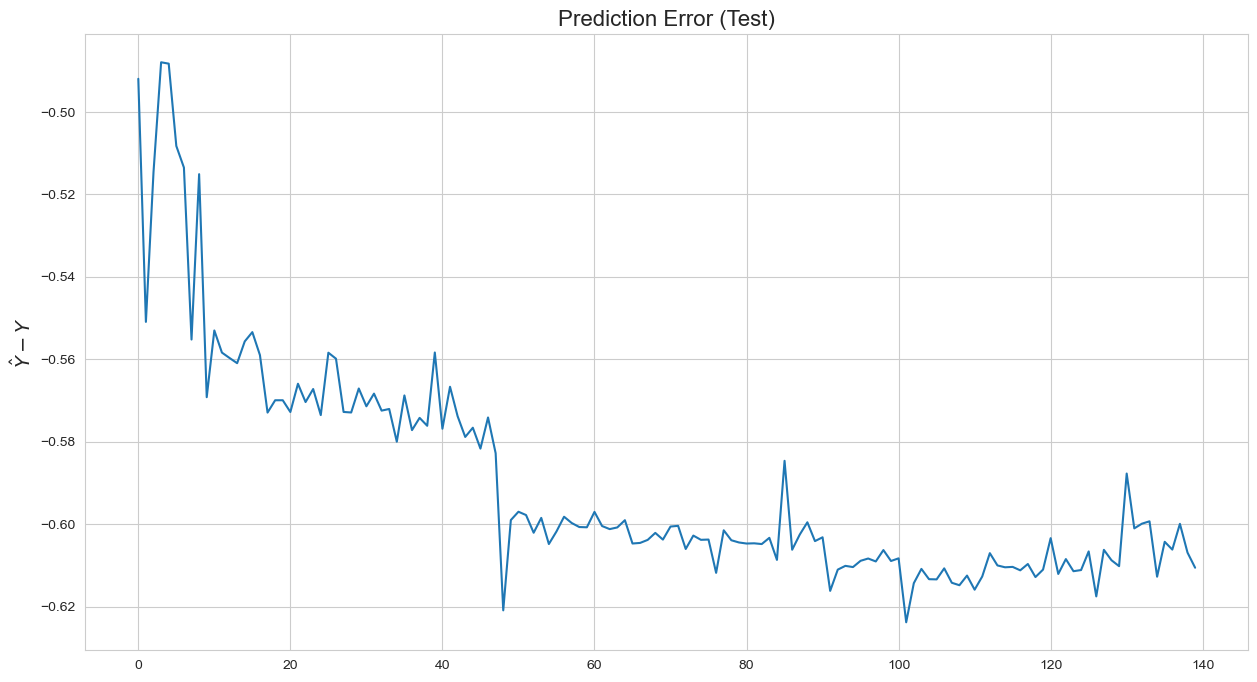

In [85]:
fig1 = plt.figure(figsize=(15,8))
plt.plot(eror_prediction_test)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.title('Prediction Error (Test)', fontsize=16);

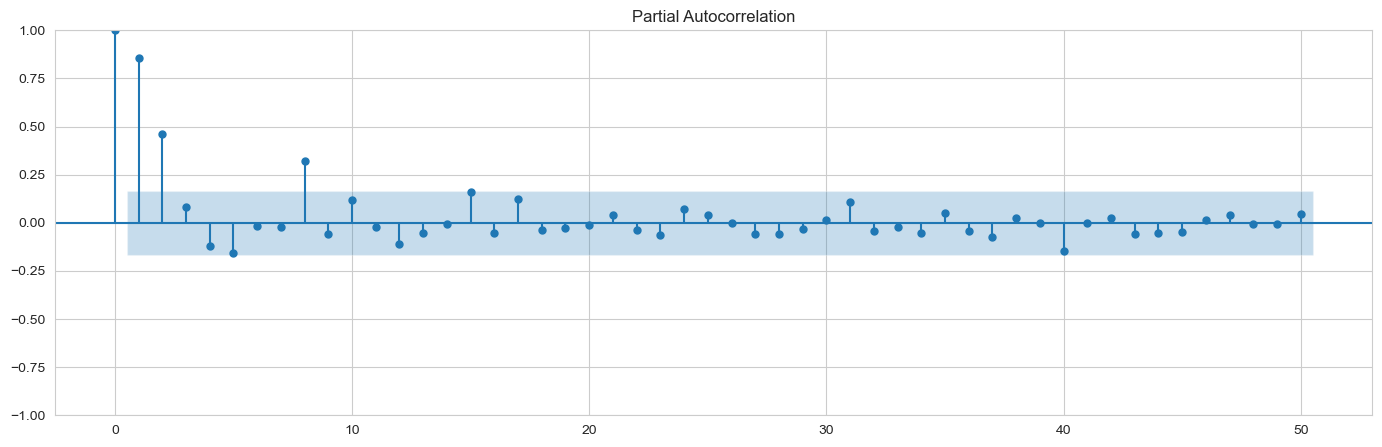

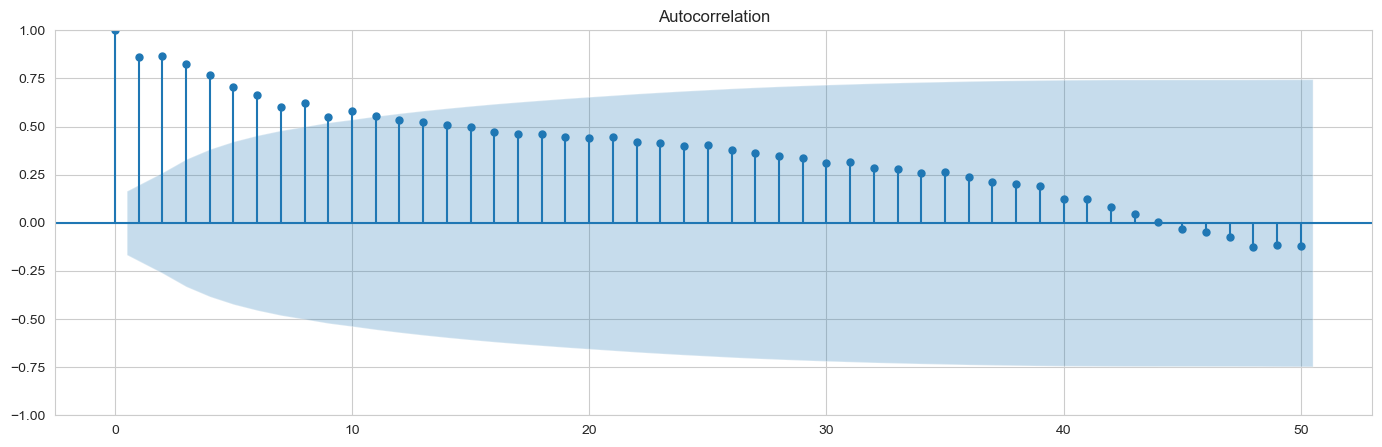

In [86]:
graficapacf=plot_pacf(eror_prediction_test,lags=50,method='ldbiased') ###Se puede usar también em method='ywmle'
graficaacf=plot_acf(eror_prediction_test,lags=50,adjusted='ldbiased')

## Tuning o búsqueda de los hiperparámetros.

In [87]:
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras import layers

## Bases de datos
Traemos la base de datos que se obtuvo del objeto del Windowgenerator y tomamos del conjunto de entrenamiento y validación, lo correspondiente a los inputs y targets de cada conjunto.

In [88]:
for batch in single_step_window.train.take(1):
    inputs_train,targets_train = batch
    

print("Input shape:", inputs_train.numpy().shape)
print("Target shape:", targets_train.numpy().shape)

Input shape: (128, 1, 1)
Target shape: (128, 1, 1)


In [89]:
for batch in single_step_window.val.take(1):
    inputs_val,targets_val = batch

print("Input shape:", inputs_val.numpy().shape)
print("Target shape:", targets_val.numpy().shape)

Input shape: (128, 1, 1)
Target shape: (128, 1, 1)


In [90]:
single_step_window.train.element_spec

(TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [91]:
input_dataset_train = single_step_window.train.map(lambda x,y: x)
target_dataset_train = single_step_window.train.map(lambda x,y: y)

In [92]:
input_dataset_train

<MapDataset element_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None)>

In [93]:
input_dataset_val = single_step_window.val.map(lambda x,y: x)
target_dataset_val = single_step_window.val.map(lambda x,y: y)

In [94]:
print(input_dataset_val)
print(target_dataset_val)


<MapDataset element_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None)>
<MapDataset element_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None)>


In [95]:
input_dataset_test = single_step_window.test.map(lambda x,y: x)
target_dataset_test = single_step_window.test.map(lambda x,y: y)

In [96]:
print(input_dataset_test)
print(target_dataset_test)

<MapDataset element_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None)>
<MapDataset element_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None)>


* El modelo que configuró para el hiperajuste se denomina hipermodelo.

Puede definir un hipermodelo a través de dos enfoques:

* Mediante el uso de una función de generador de modelos
* HyperModel la clase HyperModel de la API Keras Tuner

In [97]:
def build_model(hp):
    model = keras.Sequential()# numero de unidades ocultas multiplos de 2
    model.add(layers.Dense(units=hp.Int("num_units", min_value=32, max_value=564, step=32),# una capa oculta, numero de unidades ocultas  
                activation=hp.Choice("activation", ["relu", "tanh"])))
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):# numero de capas ocultas, hiperparametro del modelo 
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=564, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):# estrategia para evitar el sobreajuste
        model.add(layers.Dropout(rate=0.25))# le asigna el 25% de pesos mas pequeños en 0
    model.add(layers.Dense(1, activation="linear"))# capa de salida, una porque queremos predecir una variable con funcion lineal
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")# optimizar la tasa de aprendizaje
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),# metodo de optimizacion adam
        loss="mean_squared_error",# perdida media cuadrada
        metrics=["mean_squared_error"]
    )
    return model


build_model(kt.HyperParameters())

In [98]:
tuner_RandomSearch_mlp = kt.RandomSearch(# metodo de busqueda para optimizar los hiperparametros random search, hyperbank otro
    hypermodel=build_model, 
    objective="val_loss",# el objetivo es minimizar la perdida o el riesgo
    max_trials=3,# maximo numero de ensayos, tamaño de la muestra
    executions_per_trial=1,# numero de inicializaciones 
    overwrite=True,
    directory="dirsalida",# guardar en el directorio
    project_name="helloworld",# guardar en proyecto
)
#define espacio de hiperparametros

In [99]:
tuner_RandomSearch_mlp.search_space_summary()# muestra la muestra

Search space summary
Default search space size: 6
num_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 564, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 564, 'step': 32, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [100]:
stop_early=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=0)# monitorear la perdida en la validacion

In [101]:
tuner_RandomSearch_mlp.search((single_step_window.train), epochs=5, validation_data=(single_step_window.val),callbacks=[stop_early])
# estoy teniendo en cuenta la validacion para minimizar el risgo empirico

Trial 3 Complete [00h 00m 01s]
val_loss: 1.310681939125061

Best val_loss So Far: 1.1969056129455566
Total elapsed time: 00h 00m 03s
INFO:tensorflow:Oracle triggered exit


In [102]:
# Get the top 2 models.
models_mlp = tuner_RandomSearch_mlp.get_best_models(num_models=2)# tome dos modelos
best_model_mlp = models_mlp[0]# tome el mejor 
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model_mlp.build(input_shape=(64, 1, 1))
best_model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (64, 1, 352)              704       
                                                                 
 dense_1 (Dense)             (64, 1, 128)              45184     
                                                                 
 dense_2 (Dense)             (64, 1, 96)               12384     
                                                                 
 dense_3 (Dense)             (64, 1, 64)               6208      
                                                                 
 dense_4 (Dense)             (64, 1, 288)              18720     
                                                                 
 dense_5 (Dense)             (64, 1, 1)                289       
                                                                 
Total params: 83,489
Trainable params: 83,489
Non-traina

In [103]:
tuner_RandomSearch_mlp.results_summary()

Results summary
Results in dirsalida\helloworld
Showing 10 best trials
Trial summary
Hyperparameters:
num_units: 352
activation: relu
num_layers: 4
units_0: 128
dropout: False
lr: 0.0003093080953915962
units_1: 96
units_2: 64
units_3: 288
Score: 1.1969056129455566
Trial summary
Hyperparameters:
num_units: 64
activation: relu
num_layers: 4
units_0: 256
dropout: False
lr: 0.00010351289585401583
units_1: 288
units_2: 224
units_3: 224
Score: 1.310681939125061
Trial summary
Hyperparameters:
num_units: 352
activation: relu
num_layers: 4
units_0: 384
dropout: True
lr: 0.00034856443703200156
units_1: 32
units_2: 32
units_3: 32
Score: 1.3970072269439697


In [104]:
train_plus_val=single_step_window.train.concatenate(single_step_window.val)# unir conjunto validacion y entrenamiento

In [105]:
train_plus_val

<ConcatenateDataset element_spec=(TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>

In [106]:
best_hps_mlp = tuner_RandomSearch_mlp.get_best_hyperparameters(5)

## Ajuste del mejor modelo con el conjunto de entrenamiento+validación

In [107]:
# Get the top 2 hyperparameters.
best_hps_mlp = tuner_RandomSearch_mlp.get_best_hyperparameters(5)# los 5 modelos
# Build the model with the best hp.
callback=tf.keras.callbacks.EarlyStopping(monitor="loss",patience=0)
model_mlp = build_model(best_hps_mlp[0])# escoge el mejor modelo
# Fit with the entire dataset.
model_mlp.fit(train_plus_val, epochs=5,callbacks=[callback])# ajusta el mejor modelo con el conjunto de entrenamiento y validacion
# une conjunto de entrenamiento y validacion para volver a estimar los hiperparametros

Epoch 1/5
11/11 [==============================] - 1s 22ms/step - loss: 1.0595 - mean_squared_error: 1.0595
Epoch 2/5
11/11 [==============================] - 0s 18ms/step - loss: 0.8623 - mean_squared_error: 0.8623


In [108]:
model_mlp.layers[0].get_weights()[0]

array([[-0.01801078,  0.01521238, -0.08413813, -0.12780574, -0.07520305,
         0.12914188, -0.09205557, -0.10508717, -0.04954444,  0.03821567,
         0.10035926, -0.07257179,  0.02311851, -0.02902196,  0.11617731,
         0.09742076,  0.10603137, -0.0800331 , -0.05476826,  0.09873297,
        -0.02950471,  0.02344466,  0.0185798 ,  0.08932496, -0.04522042,
         0.00431533,  0.02798825, -0.02848483, -0.0798066 ,  0.06437712,
        -0.08129766, -0.04687983, -0.1171031 , -0.00815764, -0.12201273,
         0.09507153,  0.1130107 ,  0.05173498,  0.07187491,  0.04279431,
        -0.12713689, -0.00760899,  0.05358659, -0.0083043 ,  0.03837274,
         0.04541127, -0.09272559,  0.10637225,  0.05124644,  0.08465391,
         0.11064002,  0.01141594,  0.09682193,  0.13133866,  0.07534601,
         0.07906231,  0.07865986, -0.06418286,  0.08186031,  0.04036614,
        -0.08185847, -0.08423233,  0.00863472, -0.02949026, -0.07199401,
        -0.02354377,  0.01088072,  0.08231401, -0.0

In [109]:
print(model_mlp.layers[0].weights)

[<tf.Variable 'dense_6/kernel:0' shape=(1, 352) dtype=float32, numpy=
array([[-0.01801078,  0.01521238, -0.08413813, -0.12780574, -0.07520305,
         0.12914188, -0.09205557, -0.10508717, -0.04954444,  0.03821567,
         0.10035926, -0.07257179,  0.02311851, -0.02902196,  0.11617731,
         0.09742076,  0.10603137, -0.0800331 , -0.05476826,  0.09873297,
        -0.02950471,  0.02344466,  0.0185798 ,  0.08932496, -0.04522042,
         0.00431533,  0.02798825, -0.02848483, -0.0798066 ,  0.06437712,
        -0.08129766, -0.04687983, -0.1171031 , -0.00815764, -0.12201273,
         0.09507153,  0.1130107 ,  0.05173498,  0.07187491,  0.04279431,
        -0.12713689, -0.00760899,  0.05358659, -0.0083043 ,  0.03837274,
         0.04541127, -0.09272559,  0.10637225,  0.05124644,  0.08465391,
         0.11064002,  0.01141594,  0.09682193,  0.13133866,  0.07534601,
         0.07906231,  0.07865986, -0.06418286,  0.08186031,  0.04036614,
        -0.08185847, -0.08423233,  0.00863472, -0.0294

In [110]:
print(model_mlp.layers[0].bias.numpy())

[ 6.6195749e-04 -4.3010847e-03  3.5513691e-03  1.0051739e-03
  9.0489304e-04  3.3535287e-03  5.0854320e-03  2.5959602e-03
  5.3479183e-03  2.3332220e-03 -7.2912656e-04  1.3057941e-03
  1.0439917e-03 -4.9244431e-03  2.7093189e-03  3.9976002e-03
  1.3561557e-04  7.3071336e-04  3.0460786e-03 -2.5730676e-03
  3.0636578e-03 -3.1221965e-03  4.1270466e-03  3.5958721e-03
 -1.5364302e-03 -1.9018865e-03 -1.5749251e-03  8.6760370e-04
  5.1785028e-03  3.4321327e-04 -3.5536373e-03 -4.9022646e-03
 -3.4598736e-03  4.2315051e-03  5.1308577e-03  2.2589539e-03
  1.1944615e-03  3.9144927e-03 -1.2076356e-04 -1.5046402e-03
  4.8025185e-03  2.2752318e-03  1.9898922e-04  5.0756731e-03
 -2.8649573e-03 -1.8196658e-03  5.3701494e-03 -2.0225986e-03
  2.2100257e-03  2.1051066e-03  2.9993919e-03  1.5972537e-03
 -1.5640011e-03  2.2173130e-03 -3.0250370e-04  1.1058482e-03
  2.3534298e-03 -3.1794794e-03 -3.0901192e-03 -1.0169121e-03
  4.2076651e-03 -5.1842020e-03  1.8256693e-03 -4.4226800e-03
 -3.6252392e-03  5.05537

In [111]:
model_mlp.evaluate(single_step_window.test, verbose=1)

2/2 [==============================] - 0s 1ms/step - loss: 1.3028 - mean_squared_error: 1.3028


[1.3027859926223755, 1.3027859926223755]

In [112]:
model_mlp.predict(single_step_window.test).flatten()

2/2 [==============================] - 0s 1ms/step


array([-0.3533832 , -0.35094318, -0.36234698, -0.36109757, -0.35457018,
       -0.3508361 , -0.35300335, -0.35540524, -0.36588088, -0.3632636 ,
       -0.37350592, -0.37595755, -0.37855572, -0.38035455, -0.38167915,
       -0.3813018 , -0.3805917 , -0.38139236, -0.3848906 , -0.38628018,
       -0.38708973, -0.3881823 , -0.38732812, -0.387796  , -0.38738164,
       -0.38851637, -0.385885  , -0.38466617, -0.38676593, -0.3880191 ,
       -0.38748363, -0.3881109 , -0.3878075 , -0.38852778, -0.3888618 ,
       -0.39078262, -0.3894609 , -0.39052004, -0.390492  , -0.3908935 ,
       -0.3872606 , -0.38916394, -0.38805985, -0.38897145, -0.39059523,
       -0.39105538, -0.39242545, -0.39158174, -0.39297614, -0.40207896,
       -0.4026245 , -0.4025034 , -0.40260664, -0.4036008 , -0.40339687,
       -0.40465736, -0.40472993, -0.40399456, -0.40389523, -0.40405074,
       -0.4041552 , -0.40340322, -0.4037117 , -0.4040532 , -0.4041641 ,
       -0.40384674, -0.40489188, -0.40547052, -0.40564772, -0.40

Enseguida se hace la predicción devolviendose a la escala original

In [113]:
prediction_test=(model_mlp.predict(single_step_window.test, verbose=1)*train_std['Apertura']+train_mean['Apertura'])

2/2 [==============================] - 0s 1ms/step


In [114]:
print(prediction_test.shape)
print(prediction_test)

(140, 1, 1)
[[[24665.645]]

 [[24707.268]]

 [[24512.73 ]]

 [[24534.045]]

 [[24645.395]]

 [[24709.094]]

 [[24672.123]]

 [[24631.15 ]]

 [[24452.447]]

 [[24497.094]]

 [[24322.373]]

 [[24280.55 ]]

 [[24236.229]]

 [[24205.543]]

 [[24182.945]]

 [[24189.383]]

 [[24201.496]]

 [[24187.838]]

 [[24128.162]]

 [[24104.457]]

 [[24090.648]]

 [[24072.01 ]]

 [[24086.582]]

 [[24078.6  ]]

 [[24085.668]]

 [[24066.31 ]]

 [[24111.2  ]]

 [[24131.99 ]]

 [[24096.172]]

 [[24074.793]]

 [[24083.928]]

 [[24073.227]]

 [[24078.402]]

 [[24066.115]]

 [[24060.418]]

 [[24027.65 ]]

 [[24050.2  ]]

 [[24032.13 ]]

 [[24032.61 ]]

 [[24025.76 ]]

 [[24087.732]]

 [[24055.264]]

 [[24074.098]]

 [[24058.547]]

 [[24030.848]]

 [[24022.998]]

 [[23999.625]]

 [[24014.02 ]]

 [[23990.232]]

 [[23834.947]]

 [[23825.64 ]]

 [[23827.707]]

 [[23825.945]]

 [[23808.986]]

 [[23812.465]]

 [[23790.963]]

 [[23789.725]]

 [[23802.27 ]]

 [[23803.965]]

 [[23801.312]]

 [[23799.53 ]]

 [[23812.357

In [115]:
i=1
for batch in target_dataset_test.take(2):
    if i==1:
        targets_test = batch.numpy()
    elif i>1:
        targets_test_aux = batch.numpy()
        targets_test=np.append(targets_test,targets_test_aux)
    i=i+1
print(targets_test.shape)
true_series=targets_test*train_std['Apertura']+train_mean['Apertura']
true_series=true_series.reshape((140,1,1))
print(true_series.shape)

(140,)
(140, 1, 1)


RECM: 230383.6083057994


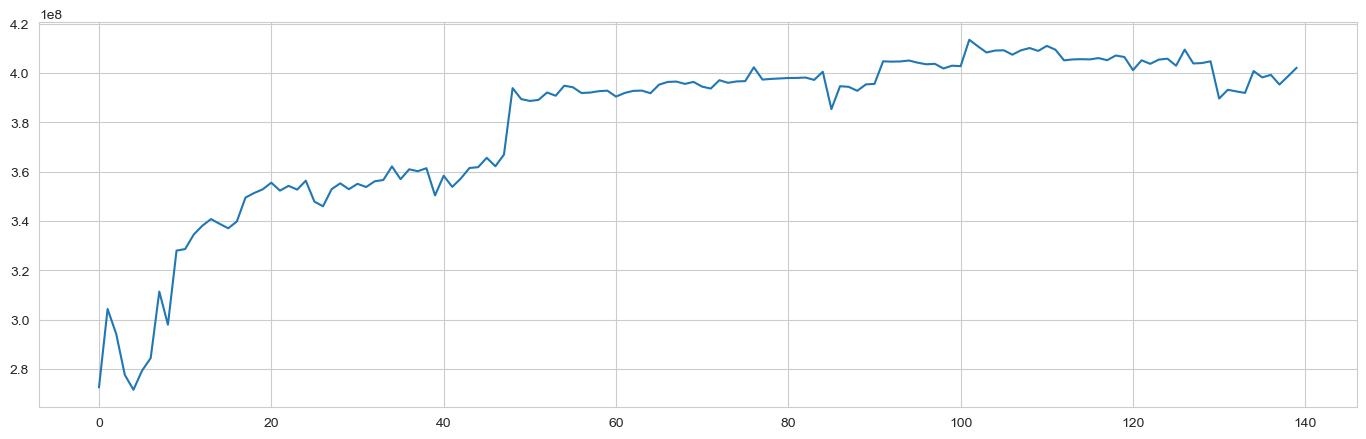

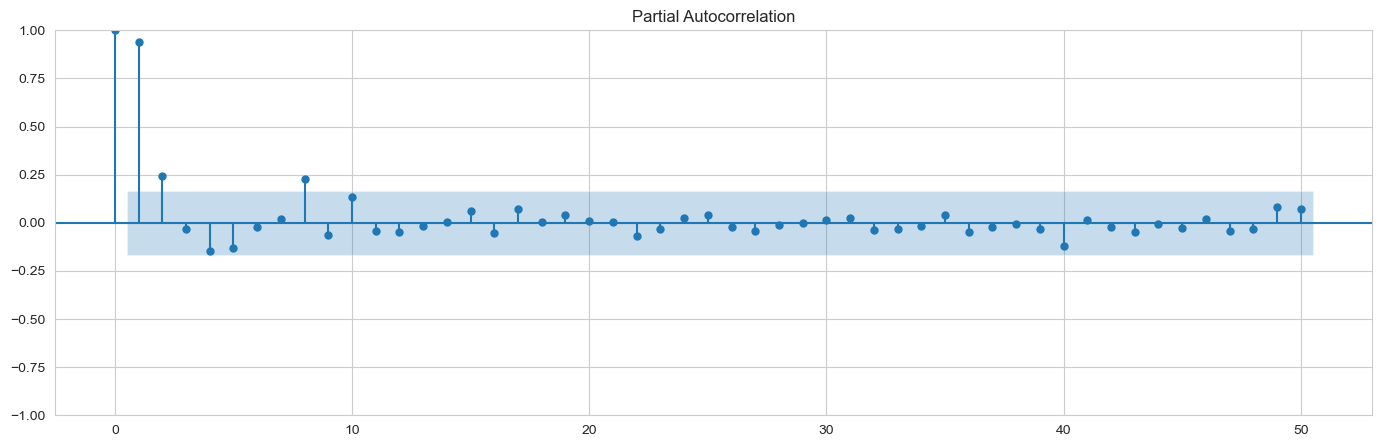

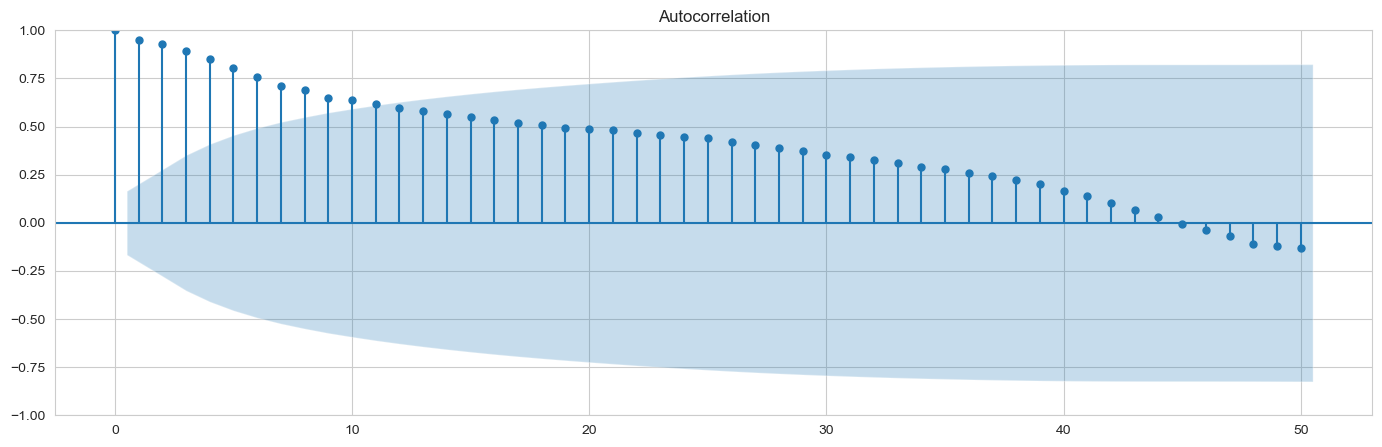

In [116]:
errors_squared=tf.keras.metrics.mean_squared_error(true_series, prediction_test).numpy()
print("RECM:",errors_squared.sum()**0.5)
plt.plot(errors_squared)
raficapacf=plot_pacf(errors_squared,lags=50,method='ldbiased') ###Se puede usar también em method='ywmle'
graficaacf=plot_acf(errors_squared,lags=50,adjusted='ldbiased')# riesgo empirico sobre el conjunto de prueba

## Gráfica en el conjunto de prueba.

In [117]:
test_index=test_df.index[:141]
test_index.values

array(['2019-05-21T00:00:00.000000000', '2019-05-20T00:00:00.000000000',
       '2019-05-19T00:00:00.000000000', '2019-05-18T00:00:00.000000000',
       '2019-05-17T00:00:00.000000000', '2019-05-16T00:00:00.000000000',
       '2019-05-15T00:00:00.000000000', '2019-05-14T00:00:00.000000000',
       '2019-05-13T00:00:00.000000000', '2019-05-12T00:00:00.000000000',
       '2019-05-11T00:00:00.000000000', '2019-05-10T00:00:00.000000000',
       '2019-05-09T00:00:00.000000000', '2019-05-08T00:00:00.000000000',
       '2019-05-07T00:00:00.000000000', '2019-05-06T00:00:00.000000000',
       '2019-05-05T00:00:00.000000000', '2019-05-04T00:00:00.000000000',
       '2019-05-03T00:00:00.000000000', '2019-05-02T00:00:00.000000000',
       '2019-05-01T00:00:00.000000000', '2019-04-30T00:00:00.000000000',
       '2019-04-29T00:00:00.000000000', '2019-04-28T00:00:00.000000000',
       '2019-04-27T00:00:00.000000000', '2019-04-26T00:00:00.000000000',
       '2019-04-25T00:00:00.000000000', '2019-04-24

In [118]:
true_series_final=true_series.reshape(140)
prediction_test_final=prediction_test.reshape(140)

In [119]:
true_series_final

array([8156.4023, 7261.9023, 7359.9023, 7871.9023, 8164.801 , 7994.801 ,
       7806.4004, 6984.703 , 7190.002 , 6386.6016, 6194.301 , 5990.502 ,
       5849.4023, 5745.502 , 5775.1016, 5830.801 , 5768.002 , 5493.5996,
       5384.6016, 5321.1016, 5235.4004, 5302.4023, 5265.701 , 5298.201 ,
       5209.201 , 5415.5996, 5511.201 , 5346.502 , 5248.201 , 5290.201 ,
       5241.002 , 5264.801 , 5208.301 , 5182.1016, 5031.4004, 5135.1016,
       5052.    , 5054.201 , 5022.701 , 5307.701 , 5158.4023, 5245.002 ,
       5173.5   , 5046.1016, 5010.002 , 4902.502 , 4968.701 , 4859.301 ,
       4145.1016, 4102.301 , 4111.801 , 4103.701 , 4025.7012, 4041.7012,
       3942.8008, 3937.1016, 3994.8008, 4002.5996, 3990.4004, 3982.2012,
       4041.2012, 4017.002 , 3990.2012, 3981.502 , 4006.4004, 3924.4004,
       3879.002 , 3865.1016, 3885.9023, 3870.3027, 3915.2012, 3944.4023,
       3865.6016, 3875.1016, 3863.1016, 3857.2012, 3715.9023, 3809.7012,
       3823.2031, 3821.9004, 3816.7012, 3814.6016, 

Text(0, 0.5, 'Y y $\\hat{Y}$ en conjunto de prueba')

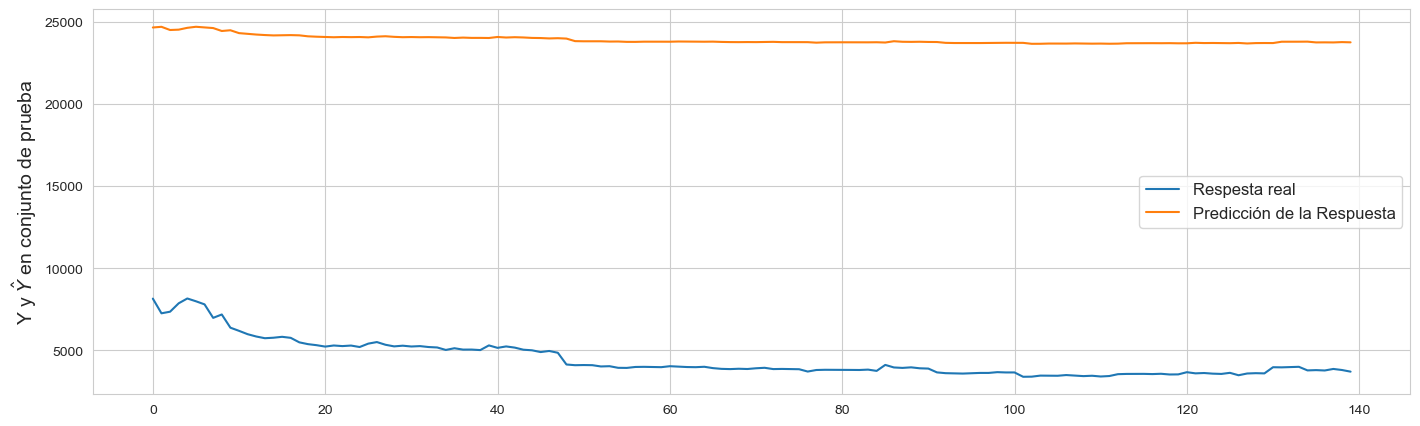

In [120]:
plt.plot(true_series_final)
plt.plot(prediction_test_final)
plt.legend(['Respesta real','Predicción de la Respuesta'],loc="best", fontsize=12)
plt.ylabel('Y y $\hat{Y}$ en conjunto de prueba', fontsize=14)

## RNN(LSTM)

In [121]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True,activation='tanh'),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
# la red tiene una sola capa, de 64 unidades, que retorna secuencias, con su respectiva funcion de activacion, el reconoce de entrada
# una capa de salida, con numero de unidades uno porque la respuesta es univariada

In [122]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', lstm_model(single_step_window.example[0]).shape)

Input shape: (128, 1, 1)
Output shape: (128, 1, 1)


In [123]:
history = compile_and_fit(lstm_model, single_step_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(single_step_window.val)
performance['LSTM'] = lstm_model.evaluate(single_step_window.test, verbose=0)

3/3 [==============================] - 0s 1ms/step - loss: 1.3391 - mean_absolute_error: 1.1549


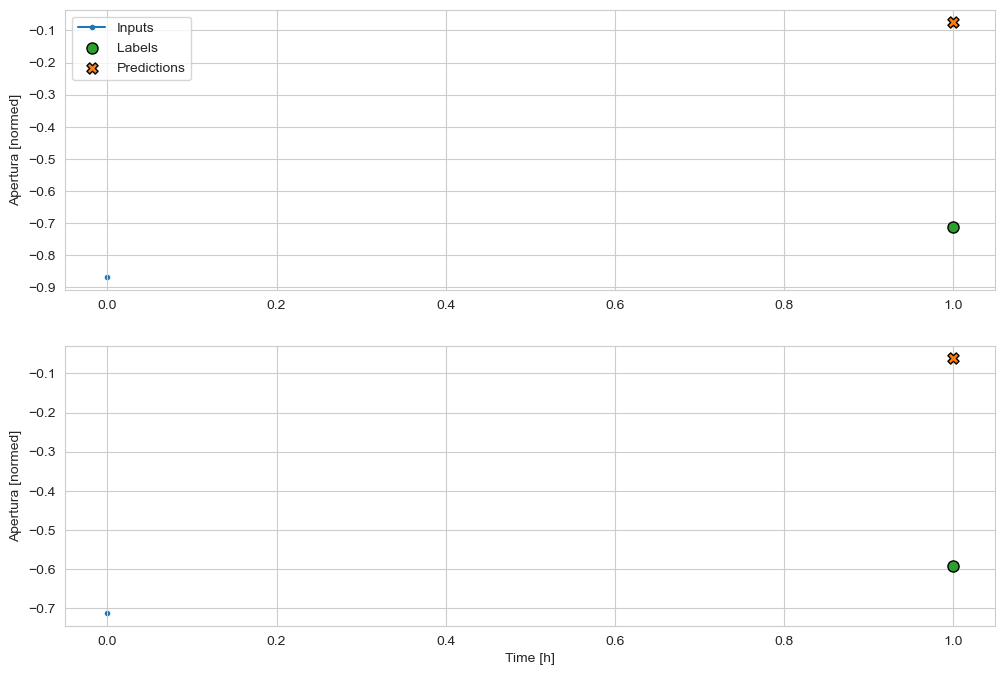

In [124]:
single_step_window.plot(lstm_model)

In [125]:
lstm_model.predict(input_predict_mlp)

1/1 [==============================] - 0s 205ms/step


array([[[-0.13532192]]], dtype=float32)

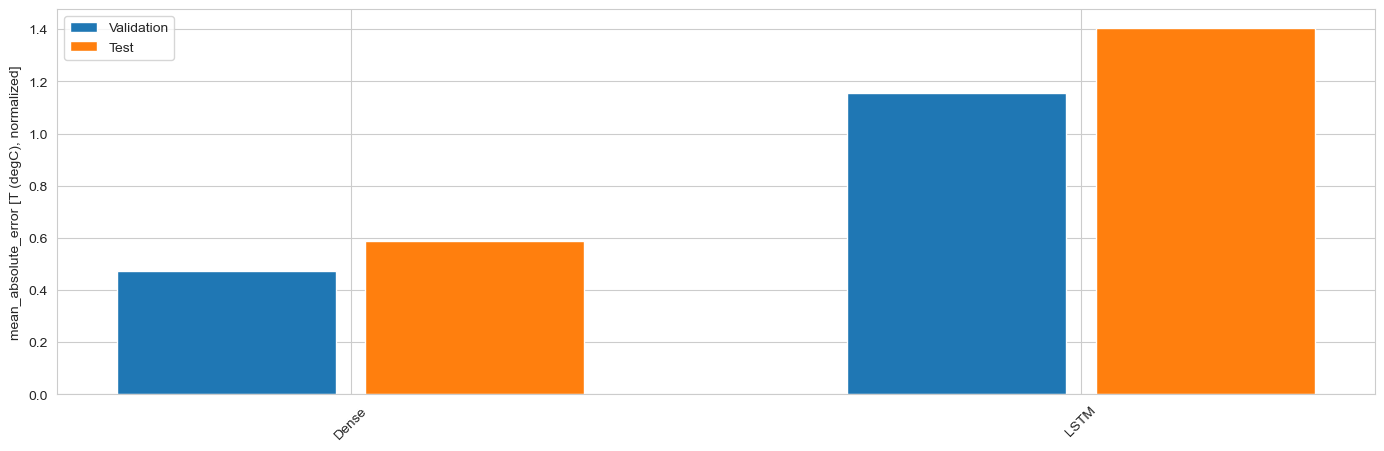

In [126]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

## Turner LSTM

In [127]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.LSTM(units=hp.Int('input_unit',min_value=32,max_value=512,step=32),activation=hp.Choice("activation", ["relu", "tanh"]),return_sequences=True))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(layers.LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),activation=hp.Choice("activation", ["relu", "tanh"]),return_sequences=True))
    model.add(layers.LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32),activation=hp.Choice("activation", ["relu", "tanh"])))
    model.add(layers.Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model

In [128]:
tuner_LSTM = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=1,
    overwrite=True,
    directory="dirsalida",
    project_name="helloworld",
)

In [129]:
stop_early=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=0)

In [130]:
tuner_LSTM.search_space_summary()

Search space summary
Default search space size: 6
input_unit (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
lstm_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
layer_2_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}


In [131]:
tuner_LSTM.search((single_step_window.train), epochs=5, validation_data=(single_step_window.val),callbacks=[stop_early])

Trial 3 Complete [00h 00m 04s]
val_loss: 1.612999439239502

Best val_loss So Far: 1.6082395315170288
Total elapsed time: 00h 00m 11s
INFO:tensorflow:Oracle triggered exit


In [133]:
# Get the top 2 models.
models_LSTM = tuner_LSTM.get_best_models(num_models=2)
best_model_LSTM = models_LSTM[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model_LSTM.build(input_shape=(64, 1, 1))
best_model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (64, 1, 64)               16896     
                                                                 
 lstm_1 (LSTM)               (64, 1, 224)              258944    
                                                                 
 lstm_2 (LSTM)               (64, 1, 32)               32896     
                                                                 
 lstm_3 (LSTM)               (64, 1, 32)               8320      
                                                                 
 lstm_4 (LSTM)               (64, 64)                  24832     
                                                                 
 dropout (Dropout)           (64, 64)                  0         
                                                                 
 dense (Dense)               (64, 1)                   6

In [134]:
tuner_LSTM.results_summary()

Results summary
Results in dirsalida\helloworld
Showing 10 best trials
Trial summary
Hyperparameters:
input_unit: 64
activation: relu
n_layers: 3
lstm_0_units: 224
layer_2_neurons: 64
Dropout_rate: 0.2
lstm_1_units: 32
lstm_2_units: 32
Score: 1.6082395315170288
Trial summary
Hyperparameters:
input_unit: 480
activation: relu
n_layers: 2
lstm_0_units: 128
layer_2_neurons: 64
Dropout_rate: 0.30000000000000004
lstm_1_units: 480
lstm_2_units: 192
Score: 1.6097508668899536
Trial summary
Hyperparameters:
input_unit: 352
activation: relu
n_layers: 3
lstm_0_units: 64
layer_2_neurons: 480
Dropout_rate: 0.4
lstm_1_units: 384
lstm_2_units: 320
Score: 1.612999439239502


In [135]:
train_plus_val=single_step_window.train.concatenate(single_step_window.val)###verificar que en efecto

In [136]:
# Get the top 2 hyperparameters.
best_hps_LSTM = tuner_LSTM.get_best_hyperparameters(5)
# Build the model with the best hp.
callback=tf.keras.callbacks.EarlyStopping(monitor="loss",patience=0)
model_LSTM = build_model(best_hps_LSTM[0])
# Fit with the entire dataset.
model_LSTM.fit(train_plus_val, epochs=5,callbacks=[callback])

Epoch 1/5
11/11 [==============================] - 3s 12ms/step - loss: 1.1363 - mse: 1.1363
Epoch 2/5
11/11 [==============================] - 0s 17ms/step - loss: 1.1318 - mse: 1.1318


In [137]:
model_LSTM.predict(single_step_window.test, verbose=0)

array([[-0.00502227],
       [-0.00502227],
       [-0.00502225],
       [-0.00502225],
       [-0.00502227],
       [-0.00502227],
       [-0.00502227],
       [-0.00502226],
       [-0.00502224],
       [-0.00502225],
       [-0.00502223],
       [-0.00502222],
       [-0.00502222],
       [-0.00502222],
       [-0.00502221],
       [-0.00502221],
       [-0.00502222],
       [-0.00502221],
       [-0.00502221],
       [-0.0050222 ],
       [-0.0050222 ],
       [-0.0050222 ],
       [-0.0050222 ],
       [-0.0050222 ],
       [-0.0050222 ],
       [-0.0050222 ],
       [-0.0050222 ],
       [-0.00502221],
       [-0.0050222 ],
       [-0.0050222 ],
       [-0.0050222 ],
       [-0.0050222 ],
       [-0.0050222 ],
       [-0.0050222 ],
       [-0.0050222 ],
       [-0.0050222 ],
       [-0.0050222 ],
       [-0.0050222 ],
       [-0.0050222 ],
       [-0.00502219],
       [-0.0050222 ],
       [-0.0050222 ],
       [-0.0050222 ],
       [-0.0050222 ],
       [-0.0050222 ],
       [-0

In [138]:
model_LSTM.evaluate(single_step_window.test, verbose=0)

[2.354179859161377, 2.354179859161377]